## Section 1: Test run

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# StarDist
from stardist.models import StarDist2D, Config2D
from stardist.plot import render_label
from csbdeep.utils import normalize

In [2]:
# Check if GPU is available
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print("GPU: " + str(gpu))
print("TensorFlow: " + str(tf.__version__))

GPU: True
TensorFlow: 2.13.0


In [3]:
# Import WSI images
img_array = np.load('data/Challenge/images.npy')

In [4]:
# Amount of images (# of Images, Width, Height, Channels)
img_array.shape

(4981, 256, 256, 3)

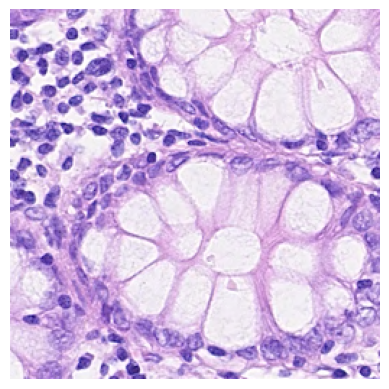

In [6]:
# Display test image:
plt.imshow(img_array[10])
plt.axis('off')
plt.show()

In [ ]:
# Available models 
StarDist2D.from_pretrained() 

In [ ]:
# Define model
HE_model = StarDist2D.from_pretrained('2D_versatile_he')

In [ ]:
# Assuming img_array is an array of 256x256 images
total_time = 0
num_images = len(img_array)

# Ensure that TensorFlow is using the GPU
with tf.device('/GPU:0'):
    for img in img_array:
        # Start timing
        start_time = time.time()
        # Process with StarDist
        he_labels, _ = HE_model.predict_instances(normalize(img))
        # End timing
        end_time = time.time()
        # Accumulate time
        total_time += end_time - start_time

In [ ]:
# Calculate average time taken per image
average_time_per_image = total_time / num_images
print(f"Average time taken per 256x256 image: {average_time_per_image} seconds")

In [ ]:
# Time for a 100000x100000 image
pixels_small_image = 256 * 256  # Number of pixels in the small image
pixels_large_image = 100000 * 100000  # Number of pixels in the large image

# Scaling the time based on the number of pixels
time_large_image = average_time_per_image * (pixels_large_image / pixels_small_image)

# Output the estimated time for the larger image
print(f"Estimated time for processing a 100000x100000 image: {time_large_image} seconds or {time_large_image / 60 / 60} hours")

In [ ]:
# Single image
he_labels, _ = HE_model.predict_instances(normalize(img_array[900]))

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(1,2,1)
plt.imshow(img_array[900], cmap="gray")
plt.axis("off")
plt.title("Input image")

plt.subplot(1,2,2)
plt.imshow(he_labels)
plt.axis("off")
plt.title("Prediction")

## Section 2: Finetuning

In [3]:
# Imports
from sklearn.model_selection import train_test_split
from stardist import fill_label_holes, calculate_extents
from stardist.matching import matching_dataset
from tqdm import tqdm
from skimage.transform import resize
import sys
np.random.seed(42)

In [4]:
# Load images and labels
images = np.load('data/Challenge/images.npy')
labels = np.load('data/Challenge/labels.npy')

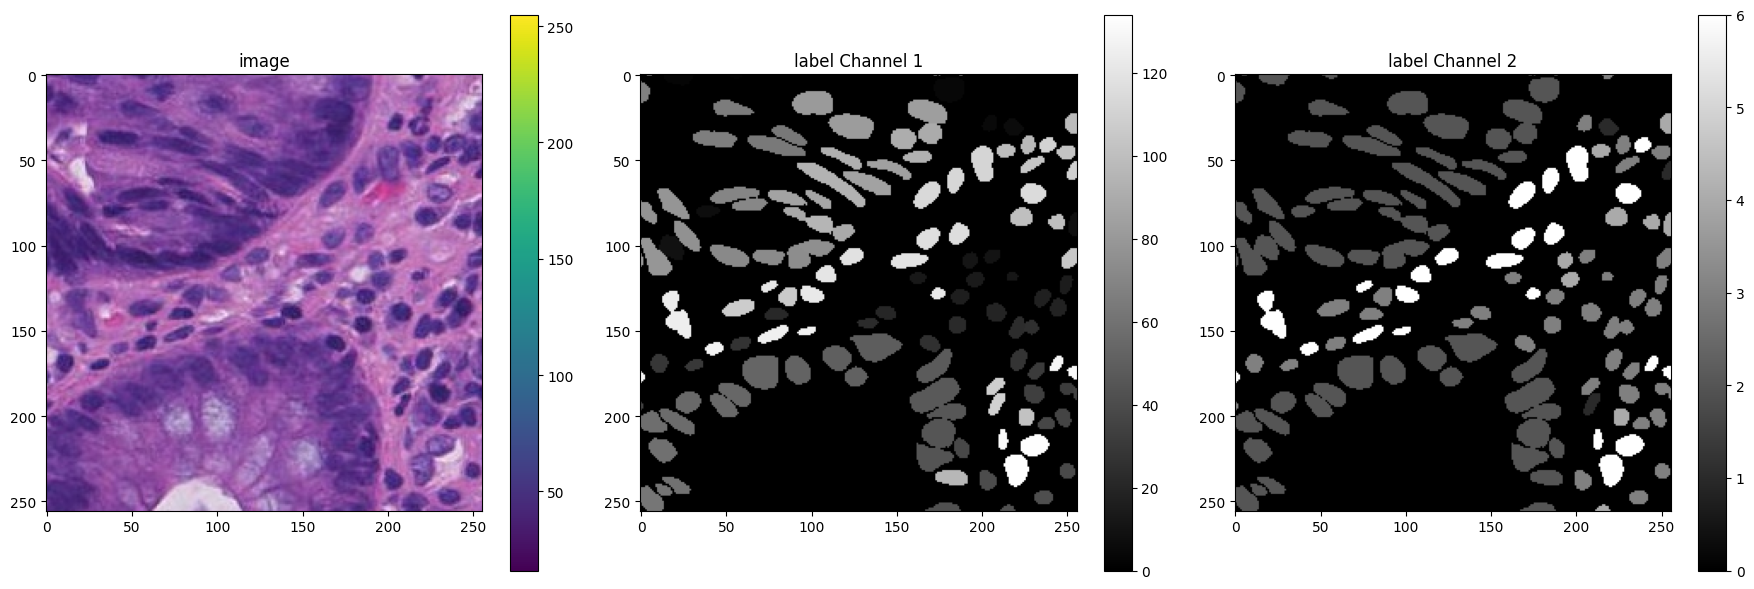

In [5]:
# Function to plot an individual channel
def plot_channel(img, title, ax, fig, cmap='gray'):
    im = ax.imshow(img, cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

# Function to plot image and its corresponding label
def plot_img_label(img, lbl, img_title="image", lbl_title="label"):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust for 3 subplots

    # Plot the image
    if img.ndim == 2 or img.shape[-1] == 1:
        # Grayscale image
        plot_channel(img, img_title, axs[0], fig, cmap='gray')
    elif img.shape[-1] == 3:
        # RGB image
        plot_channel(img, img_title, axs[0], fig, cmap=None)

    # Plot each channel of the label separately
    for i in range(2):
        plot_channel(lbl[..., i], f"{lbl_title} Channel {i+1}", axs[i+1], fig)

    plt.tight_layout()

# Example usage
i = 3333
img, lbl = images[i], labels[i]
assert img.ndim in (2,3)
img = img if (img.ndim == 2 or img.shape[-1] == 3) else img[..., 0]
plot_img_label(img, lbl)

### Filtering

In [6]:
# Filter out all cells except for Neutrophil cells:
classification_maps = labels[:, :, :, 1]
# Filter out all cells except for Neutrophil cells:
segmentation_maps = labels[:, :, :, 0]

# Create binary masks for Neutrophil cells (class 1)
neutrophil_masks = (classification_maps == 1).astype(np.uint16)

In [7]:
# Filter out all cells except for Neutrophil cells in the segmentation maps
neutrophil_segmentation_maps = segmentation_maps * neutrophil_masks

In [8]:
print(f"Total number of images before filtering: {len(images)}")

Total number of images before filtering: 4981


In [9]:
# Assuming images is a list of your images and labels is a list of your labels
filtered_images = []
filtered_labels = []

for i in range(len(images)):
    # Check if the neutrophil mask contains any non-zero values (presence of neutrophil cells)
    if np.any(neutrophil_segmentation_maps[i]):
        filtered_images.append(images[i])
        filtered_labels.append(neutrophil_segmentation_maps[i])

# Replace the original lists with the filtered lists
images = filtered_images
labels = filtered_labels

In [10]:
print(f"Total number of images after filtering: {len(images)}")

Total number of images after filtering: 1218


In [11]:
def plot_samples(images, labels, num_samples=5):
    if num_samples > len(images):
        num_samples = len(images)

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))
    fig.suptitle('Sample Images with Neutrophil Masks', fontsize=16)

    for i in range(num_samples):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title(f'Image {i}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(labels[i], cmap='gray')
        axes[i, 1].set_title(f'Label {i}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

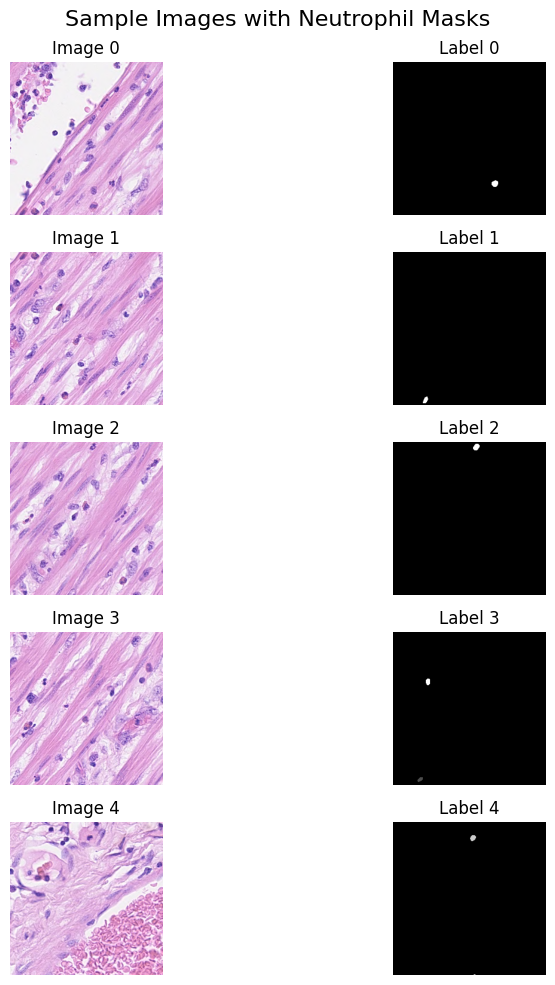

In [12]:
# Sanity Checl
plot_samples(images, labels, num_samples=5)

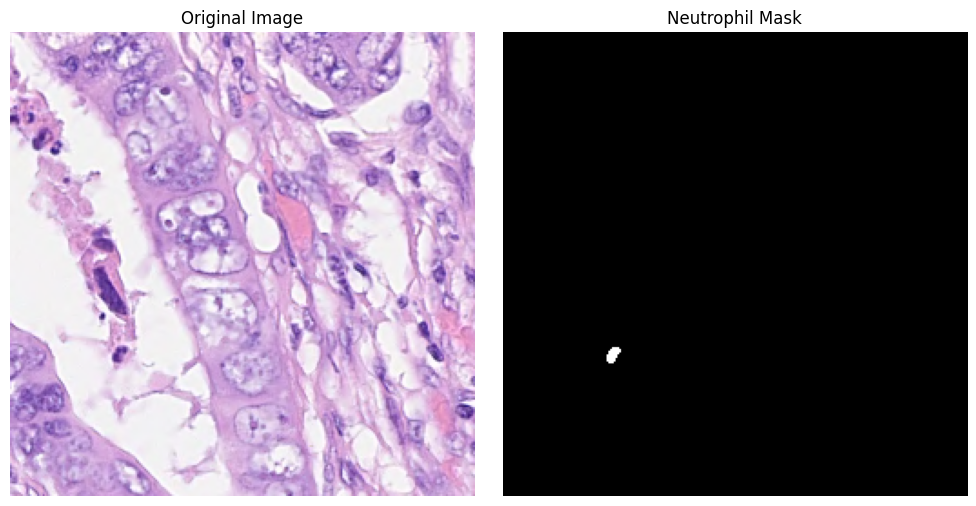

In [13]:
#Sanity check
# Function to plot image and mask side by side
def plot_image_and_mask(image, mask, img_title="Original Image", lbl_title="Neutrophil Mask"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title(img_title)
    ax[0].axis('off')
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title(lbl_title)
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

# Plotting the first image and its corresponding Neutrophil mask
plot_image_and_mask(images[20], labels[20])

### Normalizing and splitting

In [14]:
# If no third dim. then number of channels = 1.
n_channel = 1 if images[0].ndim == 2 else images[0].shape[-1]  

In [15]:
#Normalize input images and fill holes in masks
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

images_norm = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(images)]
labels_filled = [fill_label_holes(y) for y in tqdm(labels)]

Normalizing image channels independently.


100%|██████████| 1218/1218 [00:00<00:00, 3304.65it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


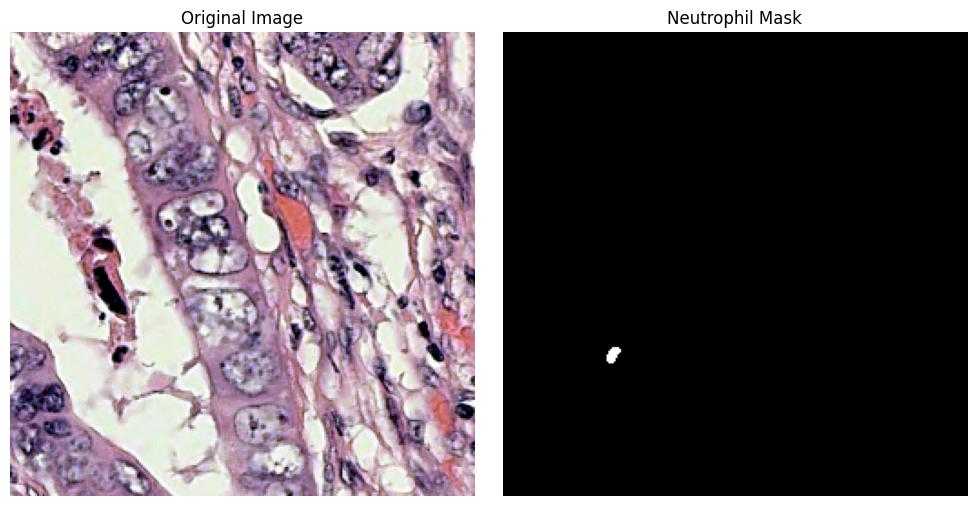

In [16]:
# Sanity check
plot_image_and_mask(images_norm[20], labels_filled[20])

In [17]:
# Split into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(images_norm, labels_filled, test_size=0.2, random_state=42)
print('number of images: %3d' % len(images_norm))
print('- training:       %3d' % len(X_train))
print('- validation:     %3d' % len(X_val))

number of images: 1218
- training:       974
- validation:     244


### Training set-up

In [19]:
# Check config to get an idea about all parameters
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [18]:
#Number of radial directions for the star-convex polygon.
n_rays = 128

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (1,1)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    n_classes   = None,
    unet_n_depth = 4,
    unet_kernel_size = (3,3),
    unet_n_filter_base = 64,
    train_learning_rate = 0.0003,
    train_batch_size = 4,
    backbone = "unet",
    train_dist_loss = 'mae',
    train_reduce_lr = {'factor': 0.5, 'patience': 40, 'min_delta': 0},

    
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(1, 1), n_channel_in=3, n_channel_out=129, n_classes=None, n_dim=2, n_rays=128, net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=4, unet_n_filter_base=64, unet_pool=(2, 2), unet_prefix=''

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 129,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 128,
 'grid': (1, 1),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 4,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 64,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003

In [20]:
# Save model to the specified directory
model = StarDist2D(conf, name='neutrophil_segmentation_more_augmentation', basedir='models/')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [21]:
# Define the network field of view to size larger than the median object size
median_size = calculate_extents(list(labels_filled), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

2024-02-07 12:42:10.502345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


median object size:      [10. 10.]
network field of view :  [64 64]


In [22]:
# Define a few augmentation methods
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def random_resized_crop(img, mask, scale=(0.3, 0.7), ratio=(3. / 4., 4. / 3.), max_attempts=20):
    height, width = img.shape[:2]

    for attempt in range(max_attempts):
        target_area = np.random.uniform(*scale) * height * width
        target_ratio = np.random.uniform(*ratio)

        w = int(round(np.sqrt(target_area * target_ratio)))
        h = int(round(np.sqrt(target_area / target_ratio)))

        if np.random.uniform() < 0.5:
            w, h = h, w

        if w <= width and h <= height:
            x = np.random.randint(0, width - w + 1)
            y = np.random.randint(0, height - h + 1)

            img_cropped = img[y:y+h, x:x+w]
            mask_cropped = mask[y:y+h, x:x+w]

            img_resized = resize(img_cropped, (height, width), preserve_range=True, anti_aliasing=True).astype(img.dtype)
            mask_resized = resize(mask_cropped, (height, width), preserve_range=True, anti_aliasing=False).astype(mask.dtype)

            return img_resized, mask_resized

    # Fallback to central crop if no suitable crop is found
    center_crop = (slice(height//4, -height//4), slice(width//4, -width//4))
    img_cropped = img[center_crop]
    mask_cropped = mask[center_crop]

    img_resized = resize(img_cropped, (height, width), preserve_range=True, anti_aliasing=True).astype(img.dtype)
    mask_resized = resize(mask_cropped, (height, width), preserve_range=True, anti_aliasing=False).astype(mask.dtype)

    return img_resized, mask_resized

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    # Apply randomized resized crop first to ensure its effect is preserved
    x, y = random_resized_crop(x, y)

    # Then apply flipping and rotation, which will be less likely to undo the crop
    x, y = random_fliprot(x, y)

    # Apply intensity changes and gaussian noise last, as these are less spatially dependent
    x = random_intensity_change(x)
    sig = 0.02 * np.random.uniform(0, 1)
    x = x + sig * np.random.normal(0, 1, x.shape)

    return x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


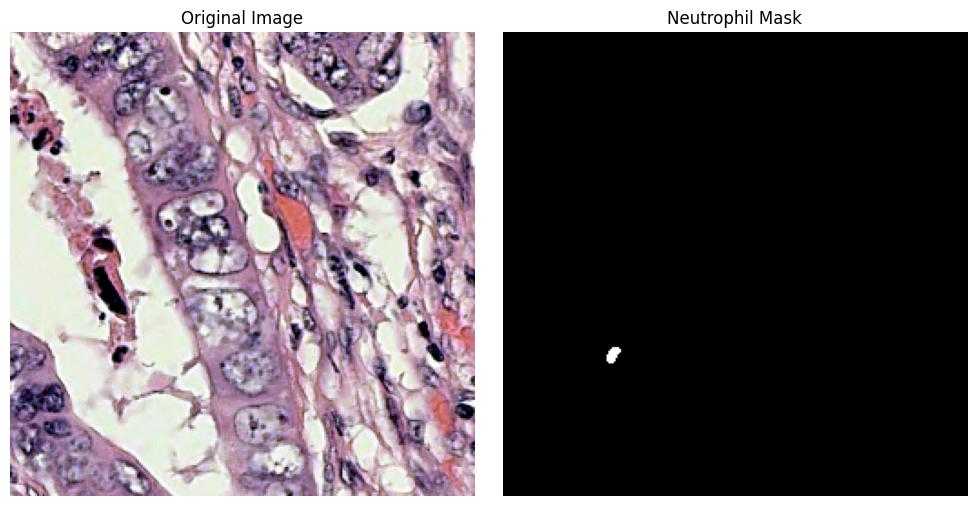

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


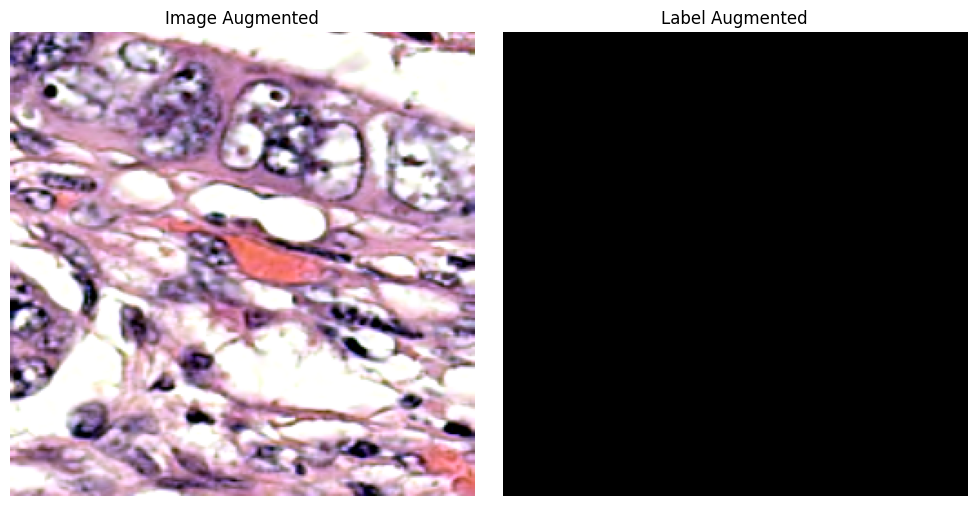

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


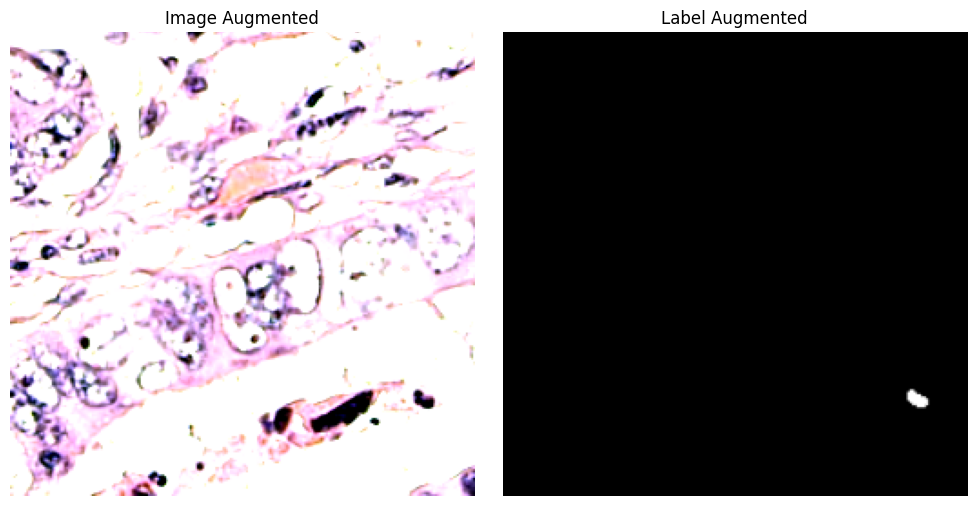

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


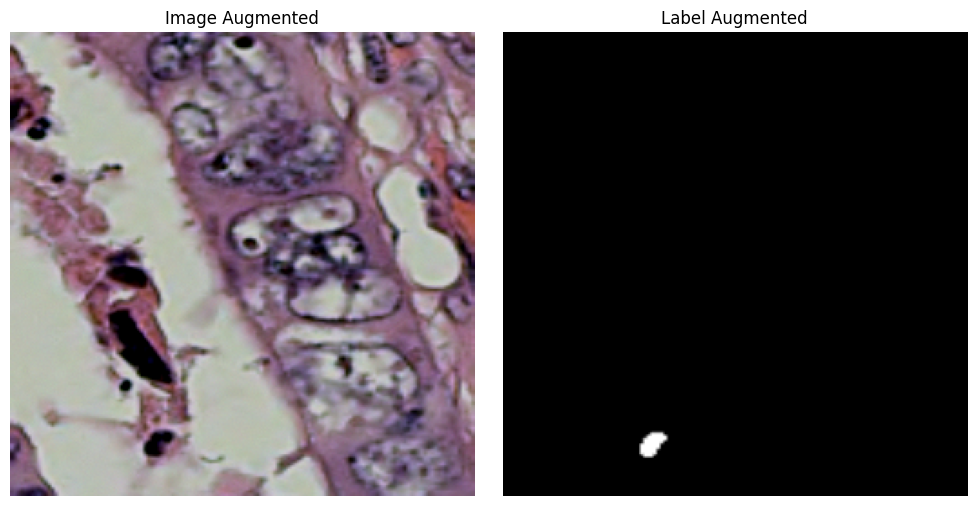

In [23]:
# Augmentation examples
img, lbl = images_norm[20], labels_filled[20]
plot_image_and_mask(img, lbl)  # Original image and label

# Show augmented images and labels
for _ in range(3):
    img_aug, lbl_aug = augmenter(img, lbl)  # 'augmenter' includes the new randomized resized crop
    plot_image_and_mask(img_aug, lbl_aug, img_title="Image Augmented", lbl_title="Label Augmented")


In [24]:
model.train(X_train, Y_train, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=100, steps_per_epoch=100)

Epoch 1/100
Cause: Unable to locate the source code of <function _gcd_import at 0x1032614c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x1032614c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x1032614c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2024-02-07 12:42:38.633465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.5892 - prob_loss: 0.0603 - dist_loss: 2.6447 - prob_kld: 0.0572 - dist_relevant_mae: 2.6447 - dist_relevant_mse: 18.7302 - dist_dist_iou_metric: 0.1535

2024-02-07 12:43:59.751316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s

2024-02-07 12:44:17.234491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 100s 987ms/step - loss: 0.5892 - prob_loss: 0.0603 - dist_loss: 2.6447 - prob_kld: 0.0572 - dist_relevant_mae: 2.6447 - dist_relevant_mse: 18.7302 - dist_dist_iou_metric: 0.1535 - val_loss: 0.0268 - val_prob_loss: 0.0268 - val_dist_loss: 6.3104e-05 - val_prob_kld: 0.0235 - val_dist_relevant_mae: 0.0000e+00 - val_dist_relevant_mse: 0.0000e+00 - val_dist_dist_iou_metric: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
100/100 [==============================] - 99s 992ms/step - loss: 0.5018 - prob_loss: 0.0331 - dist_loss: 2.3432 - prob_kld: 0.0307 - dist_relevant_mae: 2.3431 - dist_relevant_mse: 15.6289 - dist_dist_iou_metric: 0.1952 - val_loss: 0.0234 - val_prob_loss: 0.0233 - val_dist_loss: 9.1071e-05 - val_prob_kld: 0.0200 - val_dist_relevant_mae: 0.0000e+00 - val_dist_relevant_mse: 0.0000e+00 - val_dist_dist_iou_metric: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
100/100 [==============================] - 99s 994ms/step - loss: 0.4374 - prob_loss: 0.029

In [25]:
#Optimize the thresolds using the trained model
with tf.device('/GPU:0'):
    model.optimize_thresholds(X_val, Y_val)

2024-02-07 16:08:30.112603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:02<00:00,  5.45it/s, 0.105 -> 0.002]


Using optimized values: prob_thresh=0.104986, nms_thresh=0.3.
Saving to 'thresholds.json'.


### Testing

In [23]:
#Load saved model
my_model = StarDist2D(None, name='neutrophil_segmentation_more_augmentation', basedir='models/')

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [27]:
#Predict on validation images
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0] for x in tqdm(X_val)]

100%|██████████| 244/244 [00:20<00:00, 11.90it/s]


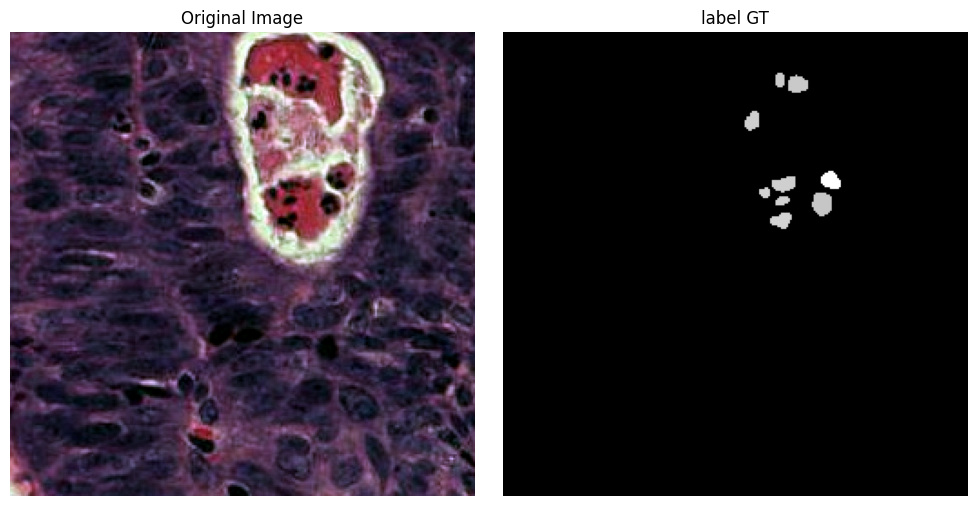

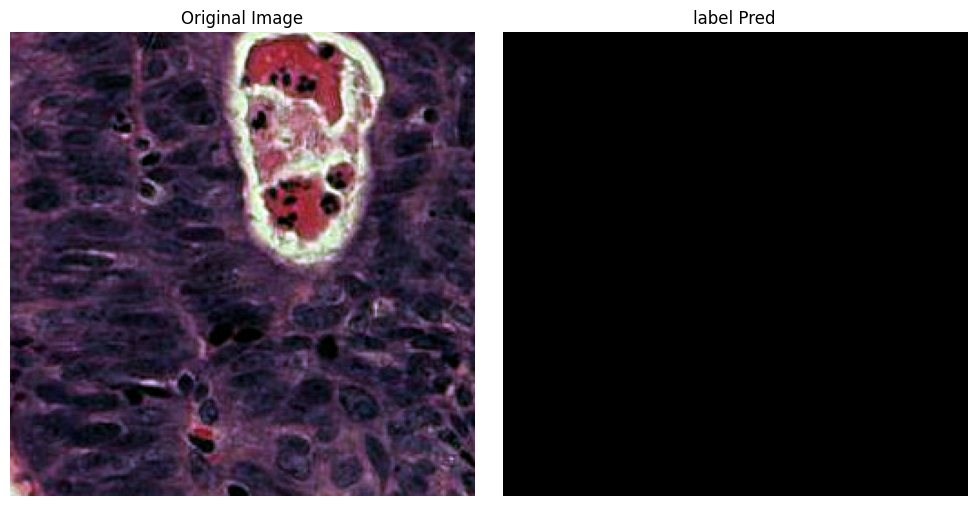

In [28]:
#PLot original labels and predcitions
plot_image_and_mask(X_val[125],Y_val[125], lbl_title="label GT")
plot_image_and_mask(X_val[125],Y_val_pred[125], lbl_title="label Pred")

In [29]:
# Calculate matching statistics
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.5)]

100%|██████████| 9/9 [00:02<00:00,  3.26it/s]


DatasetMatching(criterion='iou', thresh=0.5, fp=28, tp=3, fn=1155, precision=0.0967741935483871, recall=0.0025906735751295338, accuracy=0.002529510961214165, f1=0.005046257359125316, n_true=1158, n_pred=31, mean_true_score=0.0017394522825876872, mean_matched_score=0.6714285810788473, panoptic_quality=0.0033882014183962013, by_image=False)